### First experiments with U-Net on FOCI slp data

Try U-Net following [Xiantao et al., 2020](https://www.nature.com/articles/s41598-020-59801-x), but with only 4 convolutions, opposed to 5.
Work with real world slp samples. Omit final row, to have number of rows evenly divideable by 2 for all three max pooling operations.

Choose **mask type**: Can either have random sparsity mask, individually for each data sample ('variable'), or create only a single random mask, that is then applied to all samples identically ('fixed'). 
And optionally extend data with **augmentation factor**: Specify the number of times, each sample is to be cloned, keeping the original order.

#### Experiments:

1) **mask_type='fixed', augmentation_factor=1:** Base experiment, according to szenario to have limitet number of measurements from stations, that are fixed in their location. Fast to train, low ressources required.
2) **mask_type='variable', augmentation_factor=1:** Extends base experiment, can handle variable inputs with fixed sparsity in single model. Fits to observations from e.g. argo floats on their trajectory or well suited for e.g. sea surface temperature measurements, where varying cloud coverage limits infrared observations. In its simples form, use each sample only once. Expect worse performance, commpared to base experiment.
3) **mask_type='variable', augmentation_factor>0:** Improve performance by using each input sample multiple times, allowed by random sparsity. Try to reduce overfitting and increase generalization on unseen data. Comes at the expense of increased training time.
4) **mask_type='optimal', augmentation_factor=1:** Use optimal mask from relevance experiment with range model.
5) **mask_type='fixed', augmentation_factor=1:** Opposed to base experiment, train model with 5 convolutions, instead of 4.

Use **sparse and scaled (to [0,1]) samples as inputs**. Use **complete and scaled (to [0,1]) samples as targets**.

Got results on nesh, using GPU cluster node with batch **unet_4conv_slp_realworld.py**. Specify **mask_type** and **augmentation_factor**!

#### Results:

In general, get some nice results: Model predictions capture the main structure in slp anomalies, even for *sparsity=0.99*.

In terms of mean squarred error on training and validation data, models from our base experiment (experiment 1) trained on **fixed** sparsity mask **outperformes** models trained on **variable** mask, at least **without data augmentation** (experiment 2), as expected. But it's a trade off, since models from experiment 2 have higher flexibility: Can feed samples with specified sparsity but can freely choose, *which* inputs to use. The price is - as mentioned - a slightly worse reconstruction quality, which can be hardly recognized with human eye.

Adding data augmentation **factor=2** (experiment 3), model performance significantly improves and beats performance from our base experiment, keeping full flexibility in a sense, that we can freely choose input pixels, at least if we keep sparsity fixed.

**Note:** Need multi-run experiments for each setup, show error bars. And run experiment 3 with higher augmentation factors to validate the story.

#### Sensitivity check:

Now we have U-Net models that are trained to predict on samples with specified sparsity but allow to arbitrarily choose, *which* inputs we present. The next question then is: Can we use e.g. a model pretrained on sparsity=0.95 and feed samples with different , e.g. sparsity 0.99 and 0.9, respectively? How does validation loss change? 

That works quite nice: Especially for fixed sparsity=0.9, we find that model to almost perfectly perform in the sparsity range of [0.95, 0.75]. Our flexibility is hence further increased: Can not only freely choose, which inputs to use, but can also use a varying number of inputs, at least in a certain range!

**But note:** When we use the pre-trained model on sparsity=0.9 and use it on validation inputs with sparsity=0.95, we find even slightly lower validation loss, compared to using the *correct* model, pre-trained on sparsity=0.95. That appears to be un-intuitive and needs to be further investigated!

In [1]:
import os
import sys
sys.path.append('../reconstruct_missing_data')

from pathlib import Path
from json import dump, load

import numpy as np
from matplotlib import pyplot as plt

from data_loading import find_data_files, load_data_set, get_anomalies, clone_data, create_missing_mask, split_and_scale_data
from models import build_unet_4conv

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda, concatenate, Conv1D, Conv2D, MaxPool2D, UpSampling2D, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD
import tensorflow.keras.initializers as tfi
import tensorflow.keras.regularizers as tfr
from tensorflow.keras.utils import plot_model

# Suppress Tensorflow warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [2]:
# Set working directory, according to working directory in scripts:
os.chdir('/gxfs_work1/geomar/smomw511')

In [16]:
## Specify base parameters for experiments to compare:

# exp1: fixed mask
# exp2: variable mask, augmentation factor 1
# exp3a: variable mask, augmentation factor 2
# exp3b: variable mask, augmentation factor 3
# exp4: optimal mask

# Common parameters for all experiments:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.

# Specific parameters for exp1:
mask_types = ['fixed','fixed','fixed','fixed','fixed']
missing_types = ['discrete','discrete','discrete','discrete','discrete']
augmentation_factors = [1,1,1,1,1]
runs = ['_seed_1', '_seed_2', '_seed_3', '_seed_4', '_seed_5']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp1 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp1 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp1 = np.mean(train_loss_min_exp1,axis=0)
val_loss_min_mean_exp1 = np.mean(val_loss_min_exp1,axis=0)
train_loss_min_std_exp1 = np.std(train_loss_min_exp1,axis=0)
val_loss_min_std_exp1 = np.std(val_loss_min_exp1,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_3
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_4
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_5


In [4]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
    
print("\n")

cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_2/missing_999/epoch_10 unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_2/missing_999/missing_mask.npy unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_1/missing_99/epoch_10 unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_1/missing_99/missing_mask.npy unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_5/missing_95/epoch_10 unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_5/missing_95/missing_mask.npy unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/missing_95
cp -r unet_4conv_sst_FOCI_fixed_discrete_factor_1_seed_4/missing_90/epoch_9 unet_4conv_sst_FOCI_fixed_discrete_factor_1_final/

In [5]:
# Specific parameters for exp2:
mask_types = ['variable','variable','variable','variable','variable']
missing_types = ['discrete','discrete','discrete','discrete','discrete']
augmentation_factors = [1,1,1,1,1]
runs = ['_seed_1', '_seed_2', '_seed_3', '_seed_4', '_seed_5']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 2:
train_loss_min_exp2 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp2 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp2 = np.mean(train_loss_min_exp2,axis=0)
val_loss_min_mean_exp2 = np.mean(val_loss_min_exp2,axis=0)
train_loss_min_std_exp2 = np.std(train_loss_min_exp2,axis=0)
val_loss_min_std_exp2 = np.std(val_loss_min_exp2,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_3
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_4
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_5


In [6]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )

print("\n")

cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_5/missing_999/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_5/missing_999/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_5/missing_99/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_5/missing_99/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_1/missing_95/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_1/missing_95/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_1_final/missing_95
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_1_seed_2/missing_90/epoch_9 unet_4conv_

In [7]:
# Specific parameters for exp3a:
mask_types = ['variable','variable','variable','variable','variable']
missing_types = ['discrete','discrete','discrete','discrete','discrete']
augmentation_factors = [2,2,2,2,2]
runs = ['_seed_1', '_seed_2', '_seed_3', '_seed_4', '_seed_5']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 3:
train_loss_min_exp3a = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp3a = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp3a = np.mean(train_loss_min_exp3a,axis=0)
val_loss_min_mean_exp3a = np.mean(val_loss_min_exp3a,axis=0)
train_loss_min_std_exp3a = np.std(train_loss_min_exp3a,axis=0)
val_loss_min_std_exp3a = np.std(val_loss_min_exp3a,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_3
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_4
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_5


In [8]:
### Find epoch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
        
print("\n")

cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_2/missing_999/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_999/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_2/missing_999/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_999
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_5/missing_99/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_99/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_5/missing_99/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_99
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_3/missing_95/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_95/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_3/missing_95/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_2_final/missing_95
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_2_seed_1/missing_90/epoch_10 unet_4conv

In [9]:
# Specific parameters for exp3b:
mask_types = ['variable','variable','variable','variable','variable']
missing_types = ['discrete','discrete','discrete','discrete','discrete']
augmentation_factors = [3,3,3,3,3]
runs = ['_seed_1','_seed_2','_seed_3','_seed_4','_seed_5']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
 
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 3:
train_loss_min_exp3b = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp3b = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp3b = np.mean(train_loss_min_exp3b,axis=0)
val_loss_min_mean_exp3b = np.mean(val_loss_min_exp3b,axis=0)
train_loss_min_std_exp3b = np.std(train_loss_min_exp3b,axis=0)
val_loss_min_std_exp3b = np.std(val_loss_min_exp3b,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_1
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_2
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_3
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_4
GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_5


In [10]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_seed_'+str(int(train_loss_min_run[j])+1)+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
print("\n")

cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_5/missing_999/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_999/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_5/missing_999/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_999
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_5/missing_99/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_99/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_5/missing_99/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_99
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_1/missing_95/epoch_10 unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_95/model
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_1/missing_95/missing_mask.npy unet_4conv_sst_FOCI_variable_discrete_factor_3_final/missing_95
cp -r unet_4conv_sst_FOCI_variable_discrete_factor_3_seed_1/missing_90/epoch_10 unet_4conv

In [17]:
# Specific parameters for exp4:
mask_types = ['optimal']
missing_types = ['discrete']
augmentation_factors = [1]
runs = ['_run_2']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values_exp4 = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values_exp4),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values_exp4),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values_exp4)):

        # Get current sparsity:
        missing = missing_values_exp4[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp4 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp4 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp4 = np.mean(train_loss_min_exp4,axis=0)
val_loss_min_mean_exp4 = np.mean(val_loss_min_exp4,axis=0)
train_loss_min_std_exp4 = np.std(train_loss_min_exp4,axis=0)
val_loss_min_std_exp4 = np.std(val_loss_min_exp4,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_2


In [18]:
### Find epch and run with minimum train loss:

## First step: Find for each run the epoch with minimum train loss and the according loss values.

# Initialize storage, dimensions: (#runs, #missing value settings)
train_loss_min_epoch = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))
train_loss_min_value = np.zeros((train_loss_final_all.shape[0],train_loss_final_all.shape[1]))

# Loop over runs:
for i in range(train_loss_final_all.shape[0]):
    
    # Loop over missing value settings:
    for j in range (train_loss_final_all.shape[1]):
        
        # Find epoch with minimum loss:
        min_epoch = np.argsort(train_loss_final_all[i,j,:])[0]
        
        # Store epoch and according loss:
        train_loss_min_epoch[i,j] = min_epoch
        train_loss_min_value[i,j] = train_loss_final_all[i,j,min_epoch]
        
## Second step: Find the run with absolute minimum train loss.

# Initialize storage, dimensions: (#missing value settings)
train_loss_min_run = np.zeros(train_loss_final_all.shape[1])

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Find run with minimum loss:
    min_run = np.argsort(train_loss_min_value[:,j])[0]
    
    # Store run number:
    train_loss_min_run[j] = min_run

## Output for each missing value setting the run / epoch combination with best performance (lowest train loss):

# Loop over missing value settings:
for j in range(train_loss_final_all.shape[1]):
    
    # Rel. amount of missing values = 0.999 requires special treatment:
    if missing_values[j]==0.999:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_run_5'+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_run_5'+'/missing_' f'{int(missing_values[j]*1000)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*1000)}'
        )
        
    else:
        
        # Output: Copy optimal models
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_run_5'+'/missing_' f'{int(missing_values[j]*100)}'+
            '/epoch_'+str(int(train_loss_min_epoch[int(train_loss_min_run[j]),j]))+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'+'/model'
        )

        # Output: Copy missing masks
        print(
            'cp -r '+model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_run_5'+'/missing_' f'{int(missing_values[j]*100)}'+
            '/missing_mask.npy'+' '+
            model_config+'_'+feature_short+'_'+source+'_'+mask_types[0]+'_'+missing_types[0]+'_factor_'+
            str(augmentation_factors[0])+'_final'+'/missing_' f'{int(missing_values[j]*100)}'
        )
print("\n")

cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_999/epoch_10 unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_999/model
cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_999/missing_mask.npy unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_999
cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_99/epoch_9 unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_99/model
cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_99/missing_mask.npy unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_99
cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_95/epoch_10 unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_95/model
cp -r unet_4conv_sst_FOCI_optimal_discrete_factor_1_run_5/missing_95/missing_mask.npy unet_4conv_sst_FOCI_optimal_discrete_factor_1_final/missing_95




In [13]:
# Specific parameters for exp5:
model_config = 'unet_5conv'
mask_types = ['fixed']
missing_types = ['discrete']
augmentation_factors = [1]
runs = ['_seed_1']

# Reconstruct path to experiment:
paths = []
for i in range(len(mask_types)):
    paths.append(Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_types[i]+'_'+missing_types[i]+'_factor_'+str(augmentation_factors[i])+runs[i]))
    print(paths[i])

# Initialize storage for parameters of all experiments:
parameters_all = []

# Reload parameters for all experiments:
for path in paths:
    
    # Open corresponding parameter file and store:
    with open(path / 'parameters.json', 'r') as f:
        parameters_all.append(load(f))

# Convert to numpy array:
parameters_all = np.array(parameters_all)

# Extract certain parameters from first experiment. Note: These parameters should be identical for all experiments of interest, here.
train_val_split = parameters_all[0]['train_val_split']
missing_values = parameters_all[0]['missing_values']
scale_to = parameters_all[0]['scale_to']
epochs = parameters_all[0]['epochs']

## Get an overview of final train and validation loss, depending on rel. amount of missing values, for all experiments.
## Note: Start with epoch 0, hence untrained model.

# Initialize storage for final train and validation loss. Dimension: (#experiments, #missing values settings, #epochs+1)
train_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))
val_loss_final_all = np.zeros((len(paths),len(missing_values),epochs+1))

# Loop over experiments:
for i in range(len(paths)):
    
    # Get path for current experiment:
    path = paths[i]

    # Loop over array of desired rel. amounts of missing values:
    for j in range(len(missing_values)):

        # Get current sparsity:
        missing = missing_values[j]

        # Reload loss.
        # Rel. amount of missing values = 0.999 requires special treatment:
        if missing==0.999:
            train_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*1000)}'/ 'val_loss.npy')
        else:
            train_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'train_loss.npy')
            val_loss = np.load(path / 'missing_' f'{int(missing*100)}'/ 'val_loss.npy')
            
        # Store final train and validation loss:
        train_loss_final_all[i,j,:] = train_loss
        val_loss_final_all[i,j,:] = val_loss
        
# Get minimum train and validation loss over epochs for experiment 1:
train_loss_min_exp5 = np.min(train_loss_final_all,axis=-1)
val_loss_min_exp5 = np.min(val_loss_final_all,axis=-1)

# Get mean and std dev of minimum train and validation loss over all runs:
train_loss_min_mean_exp5 = np.mean(train_loss_min_exp5,axis=0)
val_loss_min_mean_exp5 = np.mean(val_loss_min_exp5,axis=0)
train_loss_min_std_exp5 = np.std(train_loss_min_exp5,axis=0)
val_loss_min_std_exp5 = np.std(val_loss_min_exp5,axis=0)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_5conv_sst_FOCI_fixed_discrete_factor_1_seed_1


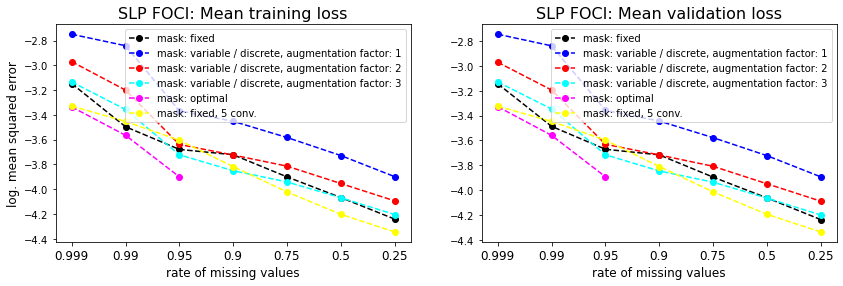

In [19]:
## High learning rate: 0.00001

# Set colors for individual experiments:
colors = ['black', 'blue', 'red', 'cyan', 'magenta', 'yellow']
linestyles = ['--', '--', '--', '--', '--', '--']

# Plot final train and validation loss over sparsity for all experiments:
fig, axes = plt.subplots(1,2,figsize=(14,4))

# exp1:
axes[0].plot(
        np.log10(train_loss_min_mean_exp1), color=colors[0],
        label = 'mask: fixed',
        marker = 'o', linestyle = linestyles[0],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp1), color=colors[0],
        label = 'mask: fixed',
        marker = 'o', linestyle = linestyles[0],
    )

# exp2:
axes[0].plot(
        np.log10(train_loss_min_mean_exp2), color=colors[1],
        label = 'mask: variable / discrete, augmentation factor: 1',
        marker = 'o', linestyle = linestyles[1],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp2), color=colors[1],
        label = 'mask: variable / discrete, augmentation factor: 1',
        marker = 'o', linestyle = linestyles[1],
    )

# exp3a:
axes[0].plot(
        np.log10(train_loss_min_mean_exp3a), color=colors[2],
        label = 'mask: variable / discrete, augmentation factor: 2',
        marker = 'o', linestyle = linestyles[2],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp3a), color=colors[2],
        label = 'mask: variable / discrete, augmentation factor: 2',
        marker = 'o', linestyle = linestyles[2],
    )

# exp3b:
axes[0].plot(
        np.log10(train_loss_min_mean_exp3b), color=colors[3],
        label = 'mask: variable / discrete, augmentation factor: 3',
        marker = 'o', linestyle = linestyles[3],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp3b), color=colors[3],
        label = 'mask: variable / discrete, augmentation factor: 3',
        marker = 'o', linestyle = linestyles[3],
    )

# exp4:
axes[0].plot(
        np.log10(train_loss_min_mean_exp4), color=colors[4],
        label = 'mask: optimal',
        marker = 'o', linestyle = linestyles[4],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp4), color=colors[4],
        label = 'mask: optimal',
        marker = 'o', linestyle = linestyles[4],
    )

# exp5:
axes[0].plot(
        np.log10(train_loss_min_mean_exp5), color=colors[5],
        label = 'mask: fixed, 5 conv.',
        marker = 'o', linestyle = linestyles[5],
    )

axes[1].plot(
        np.log10(val_loss_min_mean_exp5), color=colors[5],
        label = 'mask: fixed, 5 conv.',
        marker = 'o', linestyle = linestyles[5],
    )

# #plt.ylim(0.6, 0.8)
axes[0].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[1].set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
axes[0].set_title('SLP FOCI: Mean training loss', fontsize=16)
axes[1].set_title('SLP FOCI: Mean validation loss', fontsize=16)
axes[0].set_xlabel('rate of missing values', fontsize=12)
axes[1].set_xlabel('rate of missing values', fontsize=12)
axes[0].set_ylabel('log. mean squared error', fontsize=12)
axes[0].legend()
axes[1].legend()
plt.show() 

### Sensitivity check

- Select final models, pretrained on fixed and discrete rel. amount of missing values, **flexible mask type** and **augmentation_factor=2**.
- Feed Validation inputs with *all* sparsities into selected model.
- How does validation loss change?
- Do predictions and targets have identical scales?

In [14]:
# Specify experiment:
model_config = 'unet_4conv'
feature = 'sea-surface-temperature' # Choose either 'sea-level-pressure' or 'sea-surface-temperature' as feature.
feature_short = 'sst' # Free to set short name, to store results, e.g. 'slp' and 'sst'.
source = 'FOCI' # Choose Earth System Model, either 'FOCI' or 'CESM'.

mask_type = 'variable'
missing_type = 'discrete'
augmentation_factor = 2
run = '_final'

# Get path to stored validation loss from batch:
path = Path('GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/'+model_config+'_'+feature_short+'_'+source+'_'
                      +mask_type+'_'+missing_type+'_factor_'+str(augmentation_factor)+run)

print(path)

# Reload validation loss from sensitivity experiment (batch):
val_loss_all = np.load(path / 'val_loss_all.npy')

# Get validation loss from final model:
val_loss_final = np.diag(val_loss_all)

GitGeomar/marco-landt-hayen/reconstruct_missing_data_results/unet_4conv_sst_FOCI_variable_discrete_factor_2_final


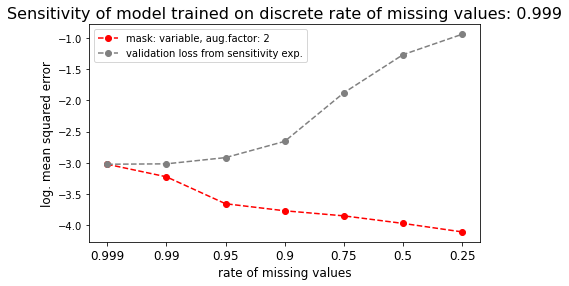

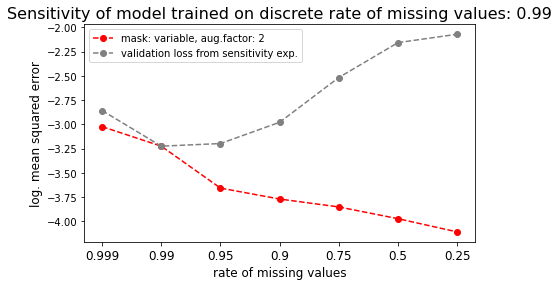

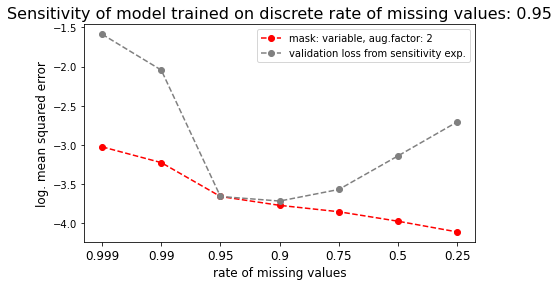

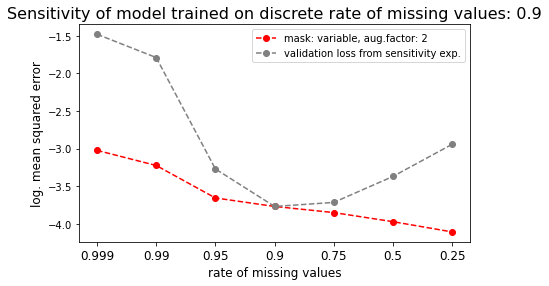

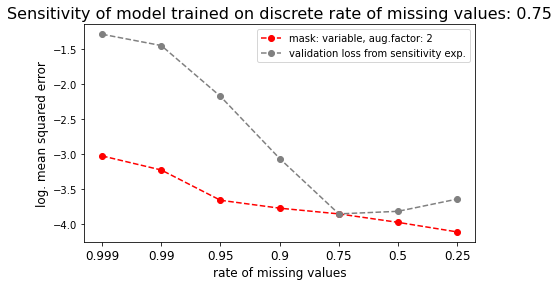

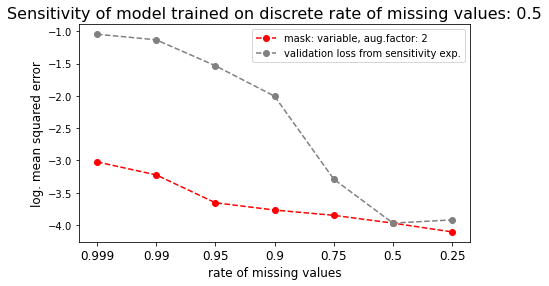

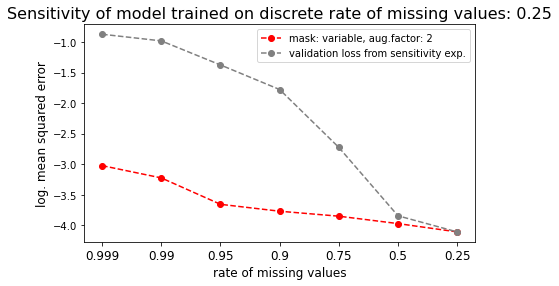

In [15]:
## Plot validation loss over rel. amounts of missing values for sensitivity experiment.

# NOTE: In the above plot, we show the MEAN of all runs as dashed red line.
# However, the sensitivity experiment is performed on the FINAL run, as best of.
# Therefore, show the corresponding final validation loss as dashed red line.
# That needs to match the fixed rel. amount of missing values in any case.

# Loop over fixed rel. amounts of missing values:
for i in range(len(missing_values)):
    
    fig, ax = plt.subplots(1,1,figsize=(7,4))

    # Validation loss, using final models:
    ax.plot(np.log10(val_loss_final), color=colors[2],
                 label = 'mask: ' + mask_type + ', aug.factor: ' + str(augmentation_factor),
                 marker = 'o', linestyle = '--',
        )

    # Final validation loss from sensitivity experiment:
    ax.plot(np.log10(val_loss_all[i]), color='grey',
                 label = 'validation loss from sensitivity exp.',
                 marker = 'o', linestyle = '--',
        )

    ax.set_xticks(np.arange(0, len(missing_values), step=1), missing_values, fontsize=12)
    ax.set_title('Sensitivity of model trained on discrete rate of missing values: '+str(missing_values[i]), fontsize=16)
    ax.set_xlabel('rate of missing values', fontsize=12)
    ax.set_ylabel('log. mean squared error', fontsize=12)
    ax.legend()
    plt.show() 

In [111]:
val_target_all.shape

(355, 72, 144)

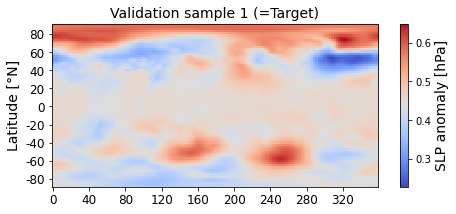

In [118]:
## Compare target to predictions:

# Pick sample number:
k=0

## Plot single validation target:
fig, ax = plt.subplots(figsize=(8, 3))

im = plt.imshow(val_target_all[k], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
cbar = plt.colorbar(im)
cbar.set_label("SLP anomaly [hPa]", fontsize=14)

plt.title('Validation sample '+str(k+1)+' (=Target)', fontsize=14)
#plt.xlabel('Longitude [°E]', fontsize=14)
plt.ylabel('Latitude [°N]', fontsize=14)
plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

plt.show()

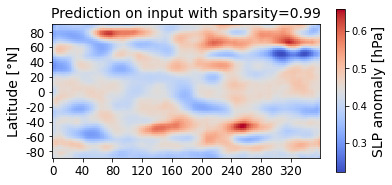

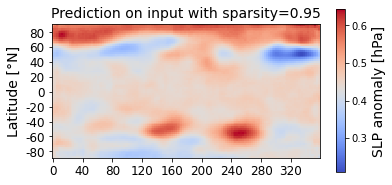

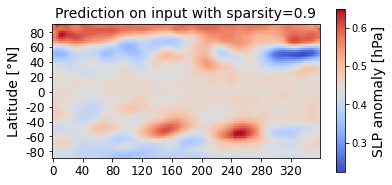

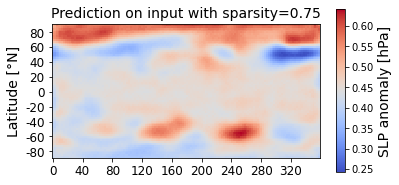

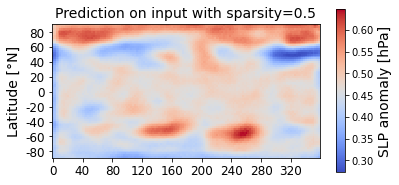

In [122]:
## Plot corresponding model prediction after final epoch:
## Use predictions from model, that is pre-trained on fixed sparsity=0.9, to infer from inputs with various sparsity.

# Loop over sparsities:
for i in range(len(sparsity_all_temp)):
    
    # Get current sparsity:
    sparsity=sparsity_all_temp[i]
    
    fig, ax = plt.subplots(figsize=(6, 3))

    im = plt.imshow(val_pred_all_sparsity_90[i,k,:,:], cmap="coolwarm", interpolation='nearest')#, vmax=0.00022)
    cbar = plt.colorbar(im)
    cbar.set_label("SLP anomaly [hPa]", fontsize=14)

    plt.title('Prediction on input with sparsity='+str(sparsity), fontsize=14)
    if j == epochs:
        plt.xlabel('Longitude [°E]', fontsize=14)
    plt.ylabel('Latitude [°N]', fontsize=14)
    plt.xticks(np.arange(0, 144, step=16), [0, 40, 80, 120, 160, 200, 240, 280, 320], fontsize=12)
    plt.yticks([4, 12, 20, 28, 36, 44, 52, 60, 68], [80, 60, 40, 20, 0, -20, -40, -60, -80], fontsize=12)

    plt.show()